# Audio reconstruction with Inpainting GAN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import random 
import copy
from numpy import savez_compressed, load
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Conv2DTranspose
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import gc
import IPython.display as ipd 

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading data

In [3]:
# load dict of arrays
dict_data = load("/content/gdrive/MyDrive/UrbanSound8K/dati/dataset8kHz.npz")
# extract the first array
data = dict_data['arr_0']
# label for each file, corresponding to the class
labels = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/dati/all_labels.csv")
labels = labels['0']
metadata = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv")
classes=np.unique(metadata["class"])
mapping=classes.tolist() 
data = data.reshape(-1,32000,1)

In [4]:
import matplotlib.pyplot as plt

def plot_spectrogram(X):
  sr=8000
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(X, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

# Inpainting GAN 
The code is inspired by: 

1) https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

2) https://github.com/ced211/master_thesis/tree/master/python

4000
8
Dec input shape:  (8, 32, 512)
Rec frame shape:  (8, 128, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 12, 64, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 32, 64)         18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 16, 128)        73856     
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 1)                 6145      
                                                                 
Total params: 98,817
Trainable params: 98,817
Non-trainable params: 0
________________________________________________

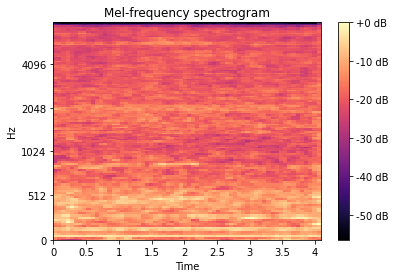

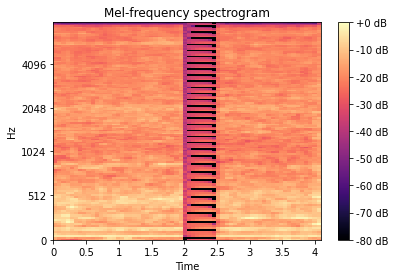

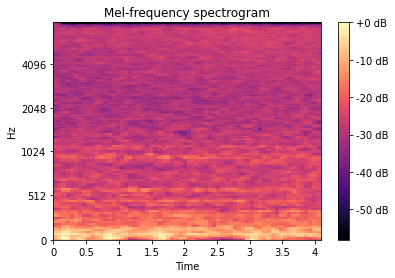

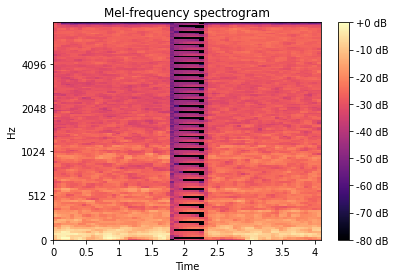

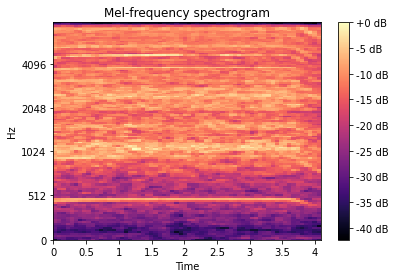

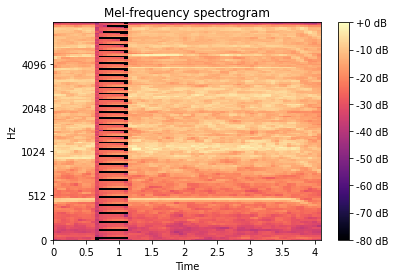

In [5]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import os
import time
import librosa.display
import numpy as np

class ContextEncoder():
    def __init__(self, corr_length):
        # 128x63 (melspectrogram); corruption of 128x16 (corresponding to 8000 (waveform)); number of channels: 1 
        self.img_rows = 128
        self.img_cols = 64 #65 w/ hop length=500, 63 w/ hop length=512
        self.mask_height = 128
        # 16=8000; 8=4000; 4=2000; 2=1000; 1=500 etc..
        self.channels = 1
        self.sr=8000 # sampling rate
        self.corruption_length = corr_length
        if(corr_length==8000):
          self.mask_width = 16 
        elif(corr_length==4000):
          self.mask_width = 8
        elif(corr_length==2000):
          self.mask_width = 4
        elif(corr_length==1000):
          self.mask_width = 2
        elif(corr_length==500):
          self.mask_width = 1
        elif(corr_length==250):
          self.mask_width = 0.5
        self.input_shape = (self.mask_width, self.mask_height, self.channels)

        optimizer = Adam(0.0001, 0.5)

        # Build the generator
        self.generator = self.build_generator_igan()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator_igan()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

        # Model initialization
        prev_frame_shape = Input(shape=self.input_shape)
        next_frame_shape = Input(shape=self.input_shape)
        gen_missing = self.generator([prev_frame_shape,next_frame_shape], training=True)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator([prev_frame_shape, gen_missing, next_frame_shape])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([prev_frame_shape,next_frame_shape] , [gen_missing, valid])
        self.combined.compile(loss=['mae', 'binary_crossentropy'], # it was mse
            loss_weights=[0.9, 0.1], # it was loss_weights=[0.999, 0.001]
            optimizer=optimizer)

    def build_generator_igan(self):

        encoder = Sequential()
        # Encoder
        encoder.add(Conv2D(32, kernel_size=(4,6), strides=(1,2), input_shape=self.input_shape, padding="same", activation="relu"))
        encoder.add(Conv2D(64, kernel_size=(4,6), strides=(1,2), padding="same", activation="relu"))
        encoder.add(Conv2D(128, kernel_size=(4,6), strides=(1,1), padding="same", activation="relu"))
        encoder.add(Conv2D(256, kernel_size=(4,6), strides=(1,1), padding="same",activation="relu"))

        # 3.4 
        spec1 = tf.keras.Input(shape=self.input_shape)
        spec3 = tf.keras.Input(shape=self.input_shape)

        spec1_encoded = encoder(spec1)
        spec3_encoded = encoder(spec3)
        
        # Layer that concatenates a list of inputs. It takes as input a list of tensors, all of the same shape except for the concatenation axis,
        # and returns a single tensor that is the concatenation of all inputs
        dec_input = Concatenate()([spec1_encoded, spec3_encoded])
        
        print("Dec input shape: ", dec_input.shape[1:]) # (16, 32, 512) 

        decoder = Sequential()
        # Decoder
        decoder.add(Conv2DTranspose(256,kernel_size=(4,6), strides=(1,2), input_shape=dec_input.shape[1:], padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(128,kernel_size=(4,6), strides=(1,2), padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(64,kernel_size=(4,6), strides=(1,1), padding="same",activation="relu")) # stride was (1,2)
        decoder.add(Conv2DTranspose(32,kernel_size=(4,6), strides=(1,1), padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(1,kernel_size=(4,6), strides=(1,1), padding="same",activation="linear"))        
        
        prediction = decoder(dec_input)
        
        return Model([spec1, spec3], prediction)

    def build_discriminator_igan(self):    

        prev_frame = tf.keras.layers.Input(shape=self.input_shape, name='prev_frame') # (16, 128, 1)
        next_frame = tf.keras.layers.Input(shape=self.input_shape, name='next_frame') # (16, 128, 1)
        print("Rec frame shape: ",self.generator.layers[-1].output_shape[1:])
        rec_frame = tf.keras.layers.Input(shape=self.generator.layers[-1].output_shape[1:], name='rec_frame') # (16, 256, 1)
        input = tf.concat([prev_frame, rec_frame, next_frame], axis=1)

        model = Sequential()
        # Without batch normalization 
        # (48, 128, 1) where 48=16*3 (prima era 5, 512, 1)
        model.add(Conv2D(32, strides=(2, 2), kernel_size=(3, 3), input_shape=(self.mask_width*3, 128, 1), padding="same",activation="relu"))
        model.add(Conv2D(64, strides=(2, 2), kernel_size=(3, 3), padding="same",activation="relu"))
        model.add(Conv2D(128, strides=(2, 2), kernel_size=(3, 3), padding="same",activation="relu"))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        last = model(input)

        return Model(inputs=[prev_frame, rec_frame, next_frame], outputs=last, name="discriminator")

    def mask_randomly(self, imgs_original):
        imgs = copy.deepcopy(imgs_original)
        # waveform corruption        
        masked_imgs = []
        imgs_mel = []
        missing_parts = np.empty((imgs.shape[0], self.corruption_length, self.channels))
        masked_imgs_mel = []
        missing_parts_mel = []
        x1 = []
        x2 = []
        x1_mel = []
        x2_mel = [] 
        previous_frames = []
        gap_frames = []
        next_frames = []
        for i, sample in enumerate(imgs):
          imgs_mel.append(librosa.feature.melspectrogram(y=sample.reshape(-1), sr=self.sr, hop_length=501))
          rand1 = random.randint(self.corruption_length, int(len(sample)-3*self.corruption_length)) 
          zeros = np.zeros(shape=sample[rand1:].shape)
          if (sample[rand1:]==zeros).all() == True or sample[rand1:rand1+self.corruption_length, :].shape[0]<8000:
              rand1 = random.randint(self.corruption_length, int(len(sample)-3*self.corruption_length)) # 16000
              missing_parts[i]=sample[rand1:rand1+self.corruption_length, :]
          else:
              missing_parts[i]=sample[rand1:rand1+self.corruption_length, :]
          sample[rand1:rand1+self.corruption_length] = 0 
          masked_imgs.append(sample)
          # waveform to mel spectrogram 
          masked_imgs_mel.append(librosa.feature.melspectrogram(y=sample.reshape(-1), sr=self.sr, hop_length=501)) # hop length = 500 ? 
          x1.append(rand1)
          x2.append(rand1+self.corruption_length)
          r_mel = round(rand1/501) # corruption starting point 
          l_mel = round(self.corruption_length/501) # corruption length (spectrogram)
          x1_mel.append(round(rand1/501))
          x2_mel.append(round((rand1+self.corruption_length)/501))

          # (16, 128) 
          previous_frames.append(imgs_mel[i][:,(r_mel-l_mel):r_mel].T) 
          #print("Previous frames shape: ", previous_frames[i].shape)
          gap_frames.append(imgs_mel[i][:, r_mel:(r_mel+l_mel)].T)
          #print("Gap frames shape: ", gap_frames[i].shape)
          next_frames.append(imgs_mel[i][:,(r_mel+l_mel):(r_mel + 2*l_mel)].T)
          #print("Next frames shape: ", next_frames[i].shape)

        # missing_parts is referred to the waveform, gap_frames is referred to the spectro
        return np.array(masked_imgs), missing_parts, masked_imgs_mel, imgs_mel, missing_parts_mel, previous_frames, gap_frames, next_frames, np.array(x1), np.array(x2), np.array(x1_mel), np.array(x2_mel)

    def train(self, epochs, batch_size=128, sample_interval=50):

        self.X_train = data
        self.data = data
        self.y_train = labels.values

        # Extract classes 
        X0 = self.X_train[(self.y_train == 0).flatten()]
        X1 = self.X_train[(self.y_train == 1).flatten()]
        X2 = self.X_train[(self.y_train == 2).flatten()]
        X3 = self.X_train[(self.y_train == 3).flatten()]
        X4 = self.X_train[(self.y_train == 4).flatten()]
        X5 = self.X_train[(self.y_train == 5).flatten()]
        X6 = self.X_train[(self.y_train == 6).flatten()]
        X7 = self.X_train[(self.y_train == 7).flatten()]
        X8 = self.X_train[(self.y_train == 8).flatten()]
        X9 = self.X_train[(self.y_train == 9).flatten()]

        # Stack arrays in sequence vertically (row wise)
        self.X_train = np.vstack((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9))
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 32000, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Select a random batch of images
          idx = np.random.randint(0, self.X_train.shape[0], batch_size)
          imgs = self.X_train[idx]

          # both referred to mel
          _, _, masked_imgs, missing_parts, imgs_mel, previous_frames, gap_frames, next_frames, _, _, _, _= self.mask_randomly(imgs)       

          # Generate a batch of new images
          for i in range(len(imgs)): # len(imgs)=64
            previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,128,1)
            gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,128,1)
            next_frames[i] = next_frames[i].reshape(1,self.mask_width,128,1)
            gen_missing = self.generator([previous_frames[i], next_frames[i]])
            #plot_spectrogram(gen_missing.numpy().reshape(16,128).T)
            original_shape = gen_missing.shape
            # Train the discriminator          
            d_loss_real = self.discriminator.train_on_batch([previous_frames[i], gap_frames[i], next_frames[i]], valid[i])
            d_loss_fake = self.discriminator.train_on_batch([previous_frames[i], gen_missing, next_frames[i]], fake[i])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # ---------------------
            #  Train Generator
            # ---------------------
            # valid = self.discriminator([prev_frame_shape, gen_missing, next_frame_shape])
            # self.combined = Model([prev_frame_shape,next_frame_shape] , [gen_missing, valid])
            g_loss = self.combined.train_on_batch([previous_frames[i], next_frames[i]], [gen_missing, valid[i]]) #sistema valid 

          # Plot the progress
          print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mae: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
          
          # If at save interval => save generated image samples
          if epoch % sample_interval == 0:
              idx = np.random.randint(0, self.X_train.shape[0], 6)
              imgs = self.X_train[idx]
              self.sample_images(epoch, imgs)
          gc.collect()   

    # bozza per salvare dataset ricostruito
    def save_images(self, imgs, path):
       reconstructed_audio = []
       cnt = 0 #contatore
       from tqdm import tqdm # progress bar
       _, _, masked_imgs, imgs_mel, _,  previous_frames, gap_frames, next_frames, x1, x2, x1_mel, x2_mel= self.mask_randomly(imgs) 
       for i in tqdm(range(len(imgs))):
          previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,128,1)
          gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,128,1)
          next_frames[i] = next_frames[i].reshape(1,self.mask_width,128,1)
          gen_missing = self.generator([previous_frames[i], next_frames[i]])
          masked_imgs[i][: , x1_mel[i]:x2_mel[i]] = gen_missing.numpy().reshape(self.mask_width,128).T
          waveform = librosa.feature.inverse.mel_to_audio(masked_imgs[i], sr=self.sr)
          reconstructed_audio.append(waveform)       
       savez_compressed(path, reconstructed_audio)

    def sample_images(self, epoch, imgs):      

        '''
         return np.array(masked_imgs), missing_parts, masked_imgs_mel, imgs_mel, missing_parts_mel, previous_frames, gap_frames, next_frames, np.array(x1), np.array(x2), np.array(x1_mel), np.array(x2_mel)
        '''
        _, _, masked_imgs, imgs_mel, _,  previous_frames, gap_frames, next_frames, x1, x2, x1_mel, x2_mel= self.mask_randomly(imgs)   

        print(len(imgs_mel))
        for i in range(3):
          previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,128,1)
          gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,128,1)
          next_frames[i] = next_frames[i].reshape(1,self.mask_width,128,1)
          gen_missing = self.generator([previous_frames[i], next_frames[i]])
          masked_imgs[i][: , x1_mel[i]:x2_mel[i]] = gen_missing.numpy().reshape(self.mask_width,128).T
          plot_spectrogram(imgs_mel[i])
          plot_spectrogram(masked_imgs[i])     
        gc.collect() 

    def save_model(self):
        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

if __name__ == '__main__':
    context_encoder = ContextEncoder(corr_length=8000)
    context_encoder.train(epochs=5, batch_size=64, sample_interval=10)
    #context_encoder.save_images(context_encoder.X_train, "/content/gdrive/MyDrive/UrbanSound8K/dati/reconstructed_8kHz.npz")

In [6]:
import gc 
del context_encoder 
gc.collect() 

8943